In [2]:
# my_imports

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.signal import find_peaks
from scipy.stats import scoreatpercentile

# Challenges and Perspectives in Recurrence Analyses of Event Time Series by Norbert Marwan

### Abstract and Motivation

The paper, Challenges and Perspectives in Recurrence Analyses of Event Time Series by Norbert Marwan, discusses the complexities and methodologies involved in analyzing event time series. Event time series, which consist of discrete events often with irregular intervals, are prevalent across various fields such as neuroscience, climate science, and engineering. Traditional time series analysis tools struggle with such data due to their non-continuous and irregular nature. Recurrence analysis, a method from nonlinear dynamics, provides an adaptable framework to analyze and compare these series. The paper explores the basic concepts, challenges, and potential future directions in recurrence analysis applied to event time series.

### Core Concepts in Recurrence Analysis

1. Event Time Series:

    * Represent sequences of discrete events defined by their timestamps (e.g., cardiac arrhythmias, landslides).
    * Often irregularly sampled and sparse, differing fundamentally from continuous time series.

1. Recurrence Analysis:

    * Based on recurrence plots (RPs), which graphically represent instances where a state recurs in a dynamical system.
    * Uses metrics like Euclidean distance for continuous data but adapts alternative metrics like edit distance for event series.
    
1. Event Metrics:

    * Edit distance and event synchronization measure the similarity and synchronization between event sequences.
    * These metrics adapt to the sparse and irregular nature of event time series.

The original code for reproducign the research is on Julia code. This was translated to Python using ChatGPT.

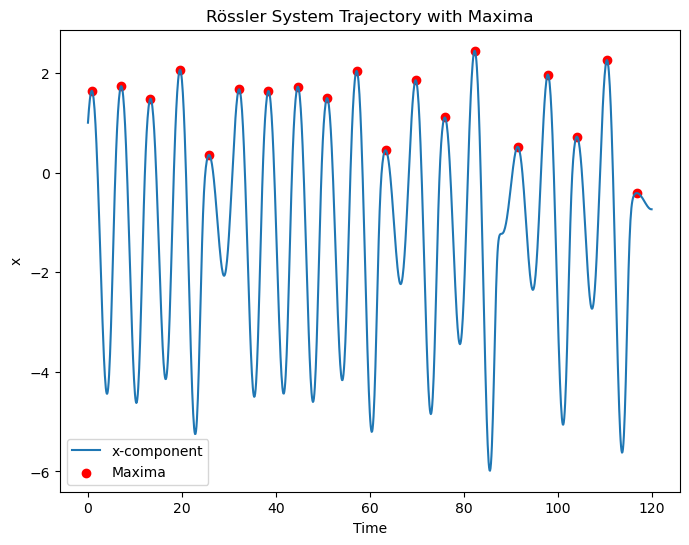

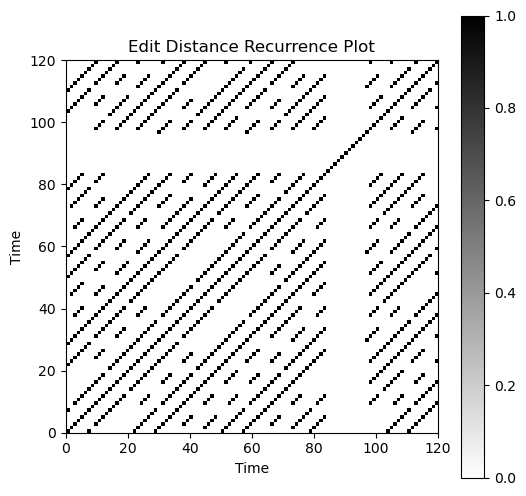

In [3]:

# Define the Rössler system
def roessler(t, x, a, b, c):
    dx1 = x[1] + a * x[0]
    dx2 = -x[2] - x[0]
    dx3 = b + x[2] * (x[1] - c)
    return [dx1, dx2, dx3]

# Parameters
a, b, c = 0.45, 2.0, 4.0
dt = 0.1
Ntrans = 10  # Transient steps to be removed
RR = 0.1  # Recurrence rate
w, ws = 150, 10  # Window parameters for edit distance
t_span = (0, 120)

# Initial conditions
x0 = [1.0, 1.0, 1.0]

# Time axis
t = np.arange(0, t_span[1] + dt, dt)

# Solve the Rössler system
sol = solve_ivp(roessler, t_span, x0, t_eval=t, args=(a, b, c))
tr = sol.y.T  # Trajectory: transpose to get time series

# Find maxima in the x-component
x_component = tr[:, 0]
peaks, _ = find_peaks(x_component)
t_events = t[peaks]  # Time points of maxima
event_values = x_component[peaks]  # Maxima values

# Plot the trajectory and maxima
plt.figure(figsize=(8, 6))
plt.plot(t, x_component, label='x-component')
plt.scatter(t_events, event_values, color='red', label='Maxima')
plt.xlabel('Time')
plt.ylabel('x')
plt.legend()
plt.title('Rössler System Trajectory with Maxima')
plt.show()

# Edit distance calculation (from previous translation)
def editdistance(t1, t2, p0, p2):
    N1 = len(t1)
    N2 = len(t2)
    G = np.zeros((N1 + 1, N2 + 1))
    G[:, 0] = np.arange(N1 + 1)
    G[0, :] = np.arange(N2 + 1)

    if N1 > 0 and N2 > 0:
        for i, t1_ in enumerate(t1):
            for j, t2_ in enumerate(t2):
                cost_del = G[i, j + 1] + p2
                cost_add = G[i + 1, j] + p2
                cost_shift = G[i, j] + p0 * abs(t1_ - t2_)
                G[i + 1, j + 1] = min(cost_del, cost_add, cost_shift)
        return G[-1, -1]
    else:
        return abs(N1 - N2) * p2

def distancematrix(t_events, t, w, ws):
    p0 = len(t_events) / (t_events[-1] - t_events[0])
    p2 = 1.0
    time_windows = t[::ws][:-(w // ws)]

    Δt = np.mean(np.diff(t))
    D = 4 * np.ones((len(time_windows), len(time_windows)))

    for i, w_i in enumerate(time_windows):
        start = np.searchsorted(t_events, w_i, side='left')
        stop = np.searchsorted(t_events, w_i + Δt * w, side='right') - 1
        if stop < start:
            continue
        i1 = np.arange(start, stop + 1)

        for j, w_j in enumerate(time_windows):
            start = np.searchsorted(t_events, w_j, side='left')
            stop = np.searchsorted(t_events, w_j + Δt * w, side='right') - 1
            if stop < start:
                continue
            i2 = np.arange(start, stop + 1)
            D[i, j] = editdistance(t_events[i1] - w_i, t_events[i2] - w_j, p0, p2)
    return D

# Distance matrix based on edit distance
D = distancematrix(t_events, t, w, ws)

# Recurrence plot (RP)
ε = scoreatpercentile(D.flatten(), RR * 100)  # Threshold based on quantile
R_ed = D < ε

plt.figure(figsize=(6, 6))
plt.imshow(R_ed, extent=(t[0], t[-1], t[0], t[-1]), origin='lower', cmap='binary')
plt.title('Edit Distance Recurrence Plot')
plt.xlabel('Time')
plt.ylabel('Time')
plt.colorbar()
plt.show()

# Save results to CSV
np.savetxt("roessler_data.csv", np.column_stack((t, tr)), delimiter=',', header='t,x,y,z', comments='')
np.savetxt("roessler_events.csv", np.column_stack((t_events, event_values)), delimiter=',', header='t_event,value', comments='')
np.savetxt("roessler_RPed.csv", R_ed.astype(int), delimiter=',', fmt='%d', header='Edit Distance RP', comments='')


### Applications

Recurrence analysis has been applied across disciplines:

* **Climate Science:** Investigating extreme rainfall events and their synchronization with large-scale weather phenomena.
* **Neuroscience:** Analyzing spike trains in neuronal activity to understand brain dynamics.
* **Engineering:** Monitoring structural failures in materials and systems under extreme conditions.


### Challenges

1. Data Quality:

    * Event series often contain missing data or uncertainties in timing (timing jitter), affecting analysis reliability.
    
1. Non-Stationarity:

    * Changes in the statistical properties of event series over time complicate the analysis.
    
1. Comparative Analysis:

    * Comparing event series with continuous data or other event series is challenging due to mismatched temporal resolutions.
    
1. Parameter Selection:

    * Choosing optimal parameters for metrics (e.g., window length for recurrence analysis, cost functions for edit distance) is non-trivial.
    
1. Sparse Data:
    * Long periods without events or sparse datasets create issues in recurrence plot computation and metric definition.


### Future Directions

1. Methodological Advancements:

    * Developing new metrics beyond edit distance, such as event coincidence analysis or ARI-SPIKE distance.
Addressing missing data with robust correction and reconstruction methods.

1. Integration with Machine Learning:

    * Utilizing recurrence plots and their quantitative features as inputs for machine learning models to classify and predict event series.

1. Causality and Synchronization:

    * Advancing methods to infer causal relationships and synchrony between different data types.

1. Uncertainty Quantification:

    * Incorporating probabilistic approaches, like Bayesian methods, to manage timing uncertainties in event data.

1. Broader Applications:

    * Expanding recurrence analysis to diverse event datasets, such as biological, geophysical, and socioeconomic phenomena.


### Conclusion

Recurrence analysis is a promising tool for analyzing event time series, offering flexibility and depth beyond traditional methods. However, addressing current challenges requires a combination of innovative metrics, computational techniques, and cross-disciplinary applications. The method’s potential for integrating with machine learning and addressing complex datasets marks it as an evolving frontier in data science.



### References

1. Norbert Marwan, Challenges and perspectives in recurrence analyses of event time series. Available at: https://arxiv.org/abs/2409.08398 (Accessed: 21 November 2024)
2. Code for reproducing the experiment. Available at: https://zenodo.org/records/7467886 (Accessed: 21 November 2024)